<a href="https://colab.research.google.com/github/christophe-asselin/projet-inf8225/blob/master/projet_INF8225.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt update && sudo apt install xvfb
!pip install gym-notebook-wrapper

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

## Vanilla PG

In [ ]:
import torch
from torch import nn
from torch.distributions import Categorical

class PolicyNet(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=64):
        super(PolicyNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, output_size),
            nn.Softmax(dim=0)
        )

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.mlp(x)

    def get_action_and_log_prob(self, x):
        action_prob = self.forward(x)
        m = Categorical(action_prob)
        action = m.sample()
        logp = m.log_prob(action)
        return action.item(), logp

    def get_action(self, x):
        action, _ = self.get_action_and_log_prob(x)
        return action

class ValueNet(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=64):
        super(ValueNet, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, 1)
        )

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.mlp(x)

In [ ]:
from dataclasses import dataclass
import numpy as np

@dataclass
class Trajectory:
    states: list
    actions: list
    rewards: list
    logp: list
    dones: list

def collect_trajectory(policy, max_num_steps):
    state_list = []
    action_list = []
    reward_list = []
    dones_list = []
    logp_list = []
    state = env.reset()
    done = False
    steps = 0
    while not done and steps <= max_num_steps:
        action, logp = policy.get_action_and_log_prob(state)
        newstate, reward, done, _ = env.step(action)
        state_list.append(state)
        action_list.append(action)
        reward_list.append(reward)
        dones_list.append(done)
        logp_list.append(logp)
        steps += 1
        state = newstate

    traj = Trajectory(states=state_list, actions=action_list,
                        rewards=reward_list, logp=logp_list, dones=dones_list)
    return traj

def discounted_sum_of_rewards(rewards, gamma):
    disc_rewards = [gamma**i * r for i, r in enumerate(rewards)]
    return [sum(disc_rewards[i:]) for i in range(len(disc_rewards))]

def vpg(env, num_iter=200, num_traj=10, max_num_steps=1000, gamma=0.98,
        policy_learning_rate=0.01, value_learning_rate=0.01,
        policy_saved_path='vpg_policy.pt', value_saved_path='vpg_value.pt'):
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n

    policy = PolicyNet(input_size, output_size)
    value = ValueNet(input_size)
    policy_optimizer = torch.optim.Adam(
        policy.parameters(), lr=policy_learning_rate)
    value_optimizer = torch.optim.Adam(
        value.parameters(), lr=value_learning_rate)

    mean_reward_list = []
    for it in range(num_iter):
        traj_list = [collect_trajectory(policy, max_num_steps) for _ in range(num_traj)]
        returns = [discounted_sum_of_rewards(traj.rewards, gamma) for traj in traj_list]

        policy_loss_terms = [-1. * traj.logp[j] * (returns[i][j] - value(traj.states[j]))
                             for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]

        policy_loss = 1. / num_traj * torch.cat(policy_loss_terms).sum()
        policy_optimizer.zero_grad()
        policy_loss.backward()
        policy_optimizer.step()

        value_loss_terms = [1. / len(traj.actions) * (value(traj.states[j]) - returns[i][j])**2.
                            for i, traj in enumerate(traj_list) for j in range(len(traj.actions))]
        value_loss = 1. / num_traj * torch.cat(value_loss_terms).sum()
        value_optimizer.zero_grad()
        value_loss.backward()
        value_optimizer.step()

        mean_reward = np.mean([sum(traj.rewards) for traj in traj_list])
        mean_reward_list.extend([sum(traj.rewards) for traj in traj_list])
        if it % 10 == 0:
            print('Iteration {}: Mean Reward = {}'.format(it, mean_reward))
            torch.save(policy.state_dict(), policy_saved_path)
            torch.save(value.state_dict(), value_saved_path)
    return policy, mean_reward_list

In [ ]:
from collections import namedtuple
import matplotlib.pyplot as plt
import gnwrapper
import gym

env = gnwrapper.Animation(gym.make('CartPole-v1'))

agent, vpg_rewards = vpg(env, num_iter=500, gamma=1.0, num_traj=1)

Iteration 0: Mean Reward = 21.0
Iteration 10: Mean Reward = 45.0
Iteration 20: Mean Reward = 48.0
Iteration 30: Mean Reward = 81.0
Iteration 40: Mean Reward = 178.0
Iteration 50: Mean Reward = 106.0
Iteration 60: Mean Reward = 110.0
Iteration 70: Mean Reward = 138.0
Iteration 80: Mean Reward = 33.0
Iteration 90: Mean Reward = 154.0
Iteration 100: Mean Reward = 135.0
Iteration 110: Mean Reward = 471.0
Iteration 120: Mean Reward = 489.0
Iteration 130: Mean Reward = 500.0
Iteration 140: Mean Reward = 390.0
Iteration 150: Mean Reward = 243.0
Iteration 160: Mean Reward = 230.0
Iteration 170: Mean Reward = 174.0
Iteration 180: Mean Reward = 500.0
Iteration 190: Mean Reward = 500.0
Iteration 200: Mean Reward = 500.0
Iteration 210: Mean Reward = 15.0
Iteration 220: Mean Reward = 500.0
Iteration 230: Mean Reward = 500.0
Iteration 240: Mean Reward = 500.0
Iteration 250: Mean Reward = 145.0
Iteration 260: Mean Reward = 16.0
Iteration 270: Mean Reward = 121.0
Iteration 280: Mean Reward = 233.0
Ite

No handles with labels found to put in legend.


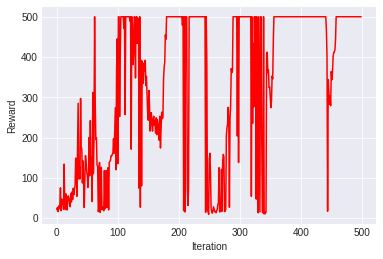

In [ ]:
plt.plot(vpg_rewards, color = 'red')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend(loc='lower right')
plt.savefig('vpg_rewards.png', format='png', dpi=300)

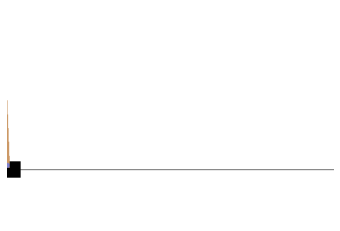

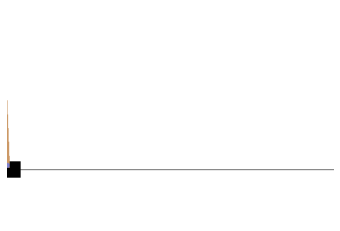

In [ ]:
state = env.reset()
for t in range(1000):
    action = agent.get_action(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()

## A2C

In [ ]:
import torch
from torch import nn
from torch.distributions import Categorical

class Actor(torch.nn.Module):
    def __init__(self, input_size, output_size, hidden_layer_size=64):
        super(Actor, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, output_size),
            nn.Softmax(dim=0)
        )

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.mlp(x)

    def get_action_and_log_prob(self, x):
        action_prob = self.forward(x)
        m = Categorical(action_prob)
        action = m.sample()
        logp = m.log_prob(action)
        return action.item(), logp

    def get_action(self, x):
        action, _ = self.get_action_and_log_prob(x)
        return action

class Critic(torch.nn.Module):
    def __init__(self, input_size, hidden_layer_size=64):
        super(Critic, self).__init__()
        self.mlp = nn.Sequential(
            nn.Linear(input_size, hidden_layer_size),
            nn.ReLU(),
            nn.Linear(hidden_layer_size, 1)
        )

    def forward(self, x):
        x = torch.from_numpy(x).float()
        return self.mlp(x)

class Memory():
    def __init__(self):
        self.log_probs = []
        self.values = []
        self.rewards = []
        self.dones = []

    def add(self, log_prob, value, reward, done):
        self.log_probs.append(log_prob)
        self.values.append(value)
        self.rewards.append(reward)
        self.dones.append(done)
    
    def clear(self):
        self.log_probs.clear()
        self.values.clear()
        self.rewards.clear()
        self.dones.clear()  
    
    def _zip(self):
        return zip(self.log_probs,
                self.values,
                self.rewards,
                self.dones)
    
    def __iter__(self):
        for data in self._zip():
            return data
    
    def reversed(self):
        for data in list(self._zip())[::-1]:
            yield data
    
    def __len__(self):
        return len(self.rewards)

In [ ]:
def a2c(env, num_iter=200, max_num_steps=1000, gamma=0.99,
        actor_learning_rate=0.01, critic_learning_rate=0.01,
        actor_saved_path='a2c_actor.pt', critic_saved_path='a2c_critic.pt'):
    
    input_size = env.observation_space.shape[0]
    output_size = env.action_space.n

    actor = Actor(input_size, output_size)
    critic = Critic(input_size)
    actor_optimizer = torch.optim.Adam(
        actor.parameters(), lr=actor_learning_rate)
    critic_optimizer = torch.optim.Adam(
        critic.parameters(), lr=critic_learning_rate)

    memory = Memory()
    reward_list = []
    for it in range(num_iter):
        state = env.reset()
        done = False
        total_reward = 0
        steps = 0
        while not done and steps <= max_num_steps:
            action, log_prob = actor.get_action_and_log_prob(state)
            newstate, reward, done, _ = env.step(action)
            memory.add(log_prob, critic(state), reward, done)
            steps += 1
            total_reward += reward
            state = newstate

        last_q_val = critic(state).detach().data.numpy()

        values = torch.stack(memory.values)
        q_vals = np.zeros((len(memory), 1))

        for i, (_, _, reward, done) in enumerate(memory.reversed()):
            last_q_val = reward + gamma * last_q_val * (1.0 - done)
            q_vals[len(memory) - 1 - i] = last_q_val

        advantage = torch.Tensor(q_vals) - values

        critic_loss = advantage.pow(2).mean()
        critic_optimizer.zero_grad()
        critic_loss.backward()
        critic_optimizer.step()

        actor_loss = (-torch.stack(memory.log_probs) * advantage.detach()).mean()
        actor_optimizer.zero_grad()
        actor_loss.backward()
        actor_optimizer.step()

        reward_list.append(total_reward)

        if it % 10 == 0:
            print('Iteration {}: Return = {}'.format(it, total_reward))
            torch.save(actor.state_dict(), actor_saved_path)
            torch.save(critic.state_dict(), critic_saved_path)

        memory.clear()
    return actor, reward_list

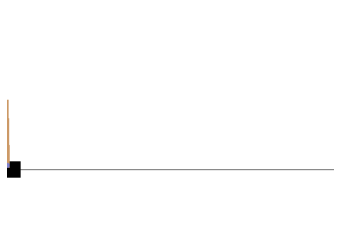

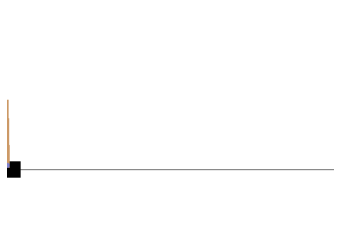

In [ ]:
env = gnwrapper.Animation(gym.make('CartPole-v1'))

agent, a2c_rewards = a2c(env, num_iter=500, gamma=0.99)
state = env.reset()
for t in range(1000):
    action = agent.get_action(state)
    env.render()
    state, reward, done, _ = env.step(action)
    if done:
        break
env.close()

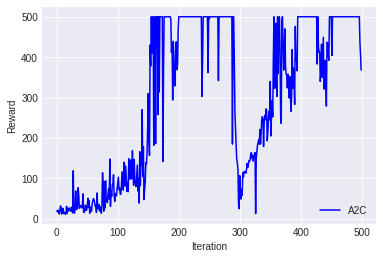

In [ ]:
plt.plot(a2c_rewards, label = 'A2C', color = 'blue')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend(loc='lower right')
plt.savefig('a2c_rewards.png', format='png', dpi=300)

## PPO

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 1.00, total step: 15.00, last_episode length: 15.00, last_episode_reward: 14.00, loss: 0.0000, lr: 0.0200
episode: 2.00, total step: 37.00, last_episode length: 22.00, last_episode_reward: 21.00, loss: -0.4333, lr: 0.0200
episode: 3.00, total step: 58.00, last_episode length: 21.00, last_episode_reward: 20.00, loss: -0.5191, lr: 0.0199
episode: 4.00, total step: 106.00, last_episode length: 48.00, last_episode_reward: 47.00, loss: -0.5213, lr: 0.0199
episode: 5.00, total step: 131.00, last_episode length: 25.00, last_episode_reward: 24.00, loss: -0.7312, lr: 0.0199
episode: 6.00, total step: 142.00, last_episode length: 11.00, last_episode_reward: 10.00, loss: -0.6947, lr: 0.0199
episode: 7.00, total step: 154.00, last_episode length: 12.00, last_episode_reward: 11.00, loss: -0.6441, lr: 0.0199
episode: 8.00, total step: 203.00, last_episode length: 49.00, last_episode_reward: 48.00, loss: -0.5998, lr: 0.0198
episode: 9.00, total step: 231.00, last_episode length: 28.00, last_

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 12.00, total step: 290.00, last_episode length: 19.00, last_episode_reward: 18.00, loss: -0.6376, lr: 0.0198
episode: 13.00, total step: 316.00, last_episode length: 26.00, last_episode_reward: 25.00, loss: -0.6161, lr: 0.0197
episode: 14.00, total step: 356.00, last_episode length: 40.00, last_episode_reward: 39.00, loss: -0.6085, lr: 0.0197
episode: 15.00, total step: 398.00, last_episode length: 42.00, last_episode_reward: 41.00, loss: -0.6279, lr: 0.0197
episode: 16.00, total step: 478.00, last_episode length: 80.00, last_episode_reward: 79.00, loss: -0.6490, lr: 0.0197
episode: 17.00, total step: 495.00, last_episode length: 17.00, last_episode_reward: 16.00, loss: -0.7375, lr: 0.0197
episode: 18.00, total step: 603.00, last_episode length: 108.00, last_episode_reward: 107.00, loss: -0.7020, lr: 0.0196
episode: 19.00, total step: 629.00, last_episode length: 26.00, last_episode_reward: 25.00, loss: -0.8738, lr: 0.0196
episode: 20.00, total step: 661.00, last_episode lengt

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 23.00, total step: 778.00, last_episode length: 43.00, last_episode_reward: 42.00, loss: -0.9000, lr: 0.0195
episode: 24.00, total step: 839.00, last_episode length: 61.00, last_episode_reward: 60.00, loss: -0.8915, lr: 0.0195
episode: 25.00, total step: 882.00, last_episode length: 43.00, last_episode_reward: 42.00, loss: -0.8609, lr: 0.0195
episode: 26.00, total step: 931.00, last_episode length: 49.00, last_episode_reward: 48.00, loss: -0.8534, lr: 0.0195
episode: 27.00, total step: 957.00, last_episode length: 26.00, last_episode_reward: 25.00, loss: -0.8050, lr: 0.0195
episode: 28.00, total step: 1102.00, last_episode length: 145.00, last_episode_reward: 144.00, loss: -0.7338, lr: 0.0194
episode: 29.00, total step: 1203.00, last_episode length: 101.00, last_episode_reward: 100.00, loss: -0.8920, lr: 0.0194
episode: 30.00, total step: 1298.00, last_episode length: 95.00, last_episode_reward: 94.00, loss: -1.0032, lr: 0.0194


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 31.00, total step: 1349.00, last_episode length: 51.00, last_episode_reward: 50.00, loss: -1.0681, lr: 0.0194
episode: 32.00, total step: 1391.00, last_episode length: 42.00, last_episode_reward: 41.00, loss: -1.0909, lr: 0.0194
episode: 33.00, total step: 1628.00, last_episode length: 237.00, last_episode_reward: 236.00, loss: -1.0328, lr: 0.0194
episode: 34.00, total step: 1701.00, last_episode length: 73.00, last_episode_reward: 72.00, loss: -1.0922, lr: 0.0193
episode: 35.00, total step: 1746.00, last_episode length: 45.00, last_episode_reward: 44.00, loss: -1.0801, lr: 0.0193
episode: 36.00, total step: 1809.00, last_episode length: 63.00, last_episode_reward: 62.00, loss: -1.0659, lr: 0.0193
episode: 37.00, total step: 1918.00, last_episode length: 109.00, last_episode_reward: 108.00, loss: -1.0709, lr: 0.0193
episode: 38.00, total step: 2006.00, last_episode length: 88.00, last_episode_reward: 87.00, loss: -0.9682, lr: 0.0193
episode: 39.00, total step: 2080.00, last_ep

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 41.00, total step: 2215.00, last_episode length: 77.00, last_episode_reward: 76.00, loss: -0.8752, lr: 0.0192
episode: 42.00, total step: 2286.00, last_episode length: 71.00, last_episode_reward: 70.00, loss: -0.8858, lr: 0.0192
episode: 43.00, total step: 2313.00, last_episode length: 27.00, last_episode_reward: 26.00, loss: -0.7761, lr: 0.0192
episode: 44.00, total step: 2388.00, last_episode length: 75.00, last_episode_reward: 74.00, loss: -0.7409, lr: 0.0191
episode: 45.00, total step: 2399.00, last_episode length: 11.00, last_episode_reward: 10.00, loss: -0.7023, lr: 0.0191
episode: 46.00, total step: 2459.00, last_episode length: 60.00, last_episode_reward: 59.00, loss: -0.6853, lr: 0.0191
episode: 47.00, total step: 2522.00, last_episode length: 63.00, last_episode_reward: 62.00, loss: -0.6389, lr: 0.0191
episode: 48.00, total step: 2618.00, last_episode length: 96.00, last_episode_reward: 95.00, loss: -0.6611, lr: 0.0191
episode: 49.00, total step: 2692.00, last_episod

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 51.00, total step: 2925.00, last_episode length: 182.00, last_episode_reward: 181.00, loss: -0.7136, lr: 0.0190
episode: 52.00, total step: 3112.00, last_episode length: 187.00, last_episode_reward: 186.00, loss: -0.9550, lr: 0.0190
episode: 53.00, total step: 3277.00, last_episode length: 165.00, last_episode_reward: 164.00, loss: -1.0628, lr: 0.0190
episode: 54.00, total step: 3414.00, last_episode length: 137.00, last_episode_reward: 136.00, loss: -1.0276, lr: 0.0189
episode: 55.00, total step: 3626.00, last_episode length: 212.00, last_episode_reward: 211.00, loss: -1.0070, lr: 0.0189
episode: 56.00, total step: 3743.00, last_episode length: 117.00, last_episode_reward: 116.00, loss: -0.9875, lr: 0.0189
episode: 57.00, total step: 3889.00, last_episode length: 146.00, last_episode_reward: 145.00, loss: -0.9870, lr: 0.0189
episode: 58.00, total step: 4011.00, last_episode length: 122.00, last_episode_reward: 121.00, loss: -0.9729, lr: 0.0189
episode: 59.00, total step: 4110

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 61.00, total step: 4416.00, last_episode length: 166.00, last_episode_reward: 165.00, loss: -0.8447, lr: 0.0188
episode: 62.00, total step: 4563.00, last_episode length: 147.00, last_episode_reward: 146.00, loss: -0.9353, lr: 0.0188
episode: 63.00, total step: 4730.00, last_episode length: 167.00, last_episode_reward: 166.00, loss: -0.9284, lr: 0.0188
episode: 64.00, total step: 4908.00, last_episode length: 178.00, last_episode_reward: 177.00, loss: -0.9271, lr: 0.0188
episode: 65.00, total step: 5082.00, last_episode length: 174.00, last_episode_reward: 173.00, loss: -0.9183, lr: 0.0187
episode: 66.00, total step: 5250.00, last_episode length: 168.00, last_episode_reward: 167.00, loss: -0.9228, lr: 0.0187
episode: 67.00, total step: 5430.00, last_episode length: 180.00, last_episode_reward: 179.00, loss: -0.8998, lr: 0.0187
episode: 68.00, total step: 5609.00, last_episode length: 179.00, last_episode_reward: 178.00, loss: -0.8926, lr: 0.0187
episode: 69.00, total step: 5805

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 71.00, total step: 6206.00, last_episode length: 212.00, last_episode_reward: 211.00, loss: -0.9087, lr: 0.0186
episode: 72.00, total step: 6393.00, last_episode length: 187.00, last_episode_reward: 186.00, loss: -0.9804, lr: 0.0186
episode: 73.00, total step: 6602.00, last_episode length: 209.00, last_episode_reward: 208.00, loss: -0.9741, lr: 0.0186
episode: 74.00, total step: 6817.00, last_episode length: 215.00, last_episode_reward: 214.00, loss: -0.9551, lr: 0.0186
episode: 75.00, total step: 7006.00, last_episode length: 189.00, last_episode_reward: 188.00, loss: -0.9758, lr: 0.0186
episode: 76.00, total step: 7244.00, last_episode length: 238.00, last_episode_reward: 237.00, loss: -0.9712, lr: 0.0185
episode: 77.00, total step: 7470.00, last_episode length: 226.00, last_episode_reward: 225.00, loss: -0.9326, lr: 0.0185
episode: 78.00, total step: 7677.00, last_episode length: 207.00, last_episode_reward: 206.00, loss: -0.9163, lr: 0.0185
episode: 79.00, total step: 7878

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 81.00, total step: 8313.00, last_episode length: 204.00, last_episode_reward: 203.00, loss: -0.8998, lr: 0.0184
episode: 82.00, total step: 8590.00, last_episode length: 277.00, last_episode_reward: 276.00, loss: -0.9201, lr: 0.0184
episode: 83.00, total step: 8839.00, last_episode length: 249.00, last_episode_reward: 248.00, loss: -0.9200, lr: 0.0184
episode: 84.00, total step: 9115.00, last_episode length: 276.00, last_episode_reward: 275.00, loss: -0.8901, lr: 0.0184
episode: 85.00, total step: 9500.00, last_episode length: 385.00, last_episode_reward: 384.00, loss: -0.8775, lr: 0.0184
episode: 86.00, total step: 9663.00, last_episode length: 163.00, last_episode_reward: 162.00, loss: -0.9334, lr: 0.0184
episode: 87.00, total step: 9970.00, last_episode length: 307.00, last_episode_reward: 306.00, loss: -0.8820, lr: 0.0183
episode: 88.00, total step: 10359.00, last_episode length: 389.00, last_episode_reward: 388.00, loss: -0.8629, lr: 0.0183
episode: 89.00, total step: 105

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 91.00, total step: 11170.00, last_episode length: 345.00, last_episode_reward: 344.00, loss: -0.8528, lr: 0.0183
episode: 92.00, total step: 11669.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8435, lr: 0.0182
episode: 93.00, total step: 12062.00, last_episode length: 393.00, last_episode_reward: 392.00, loss: -0.8006, lr: 0.0182
episode: 94.00, total step: 12561.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7200, lr: 0.0182
episode: 95.00, total step: 13060.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8932, lr: 0.0182
episode: 96.00, total step: 13307.00, last_episode length: 247.00, last_episode_reward: 246.00, loss: -0.7208, lr: 0.0182
episode: 97.00, total step: 13521.00, last_episode length: 214.00, last_episode_reward: 213.00, loss: -0.6399, lr: 0.0182
episode: 98.00, total step: 13769.00, last_episode length: 248.00, last_episode_reward: 247.00, loss: -0.8130, lr: 0.0181
episode: 99.00, total st

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 101.00, total step: 14585.00, last_episode length: 342.00, last_episode_reward: 341.00, loss: -0.8338, lr: 0.0181
episode: 102.00, total step: 14923.00, last_episode length: 338.00, last_episode_reward: 337.00, loss: -0.8439, lr: 0.0181
episode: 103.00, total step: 15234.00, last_episode length: 311.00, last_episode_reward: 310.00, loss: -0.8537, lr: 0.0180
episode: 104.00, total step: 15572.00, last_episode length: 338.00, last_episode_reward: 337.00, loss: -0.8386, lr: 0.0180
episode: 105.00, total step: 16071.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8321, lr: 0.0180
episode: 106.00, total step: 16370.00, last_episode length: 299.00, last_episode_reward: 298.00, loss: -0.6816, lr: 0.0180
episode: 107.00, total step: 16747.00, last_episode length: 377.00, last_episode_reward: 376.00, loss: -0.6224, lr: 0.0180
episode: 108.00, total step: 17094.00, last_episode length: 347.00, last_episode_reward: 346.00, loss: -0.8397, lr: 0.0180
episode: 109.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 111.00, total step: 18591.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6506, lr: 0.0179
episode: 112.00, total step: 19090.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.9028, lr: 0.0179
episode: 113.00, total step: 19424.00, last_episode length: 334.00, last_episode_reward: 333.00, loss: -0.5689, lr: 0.0179
episode: 114.00, total step: 19923.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5344, lr: 0.0178
episode: 115.00, total step: 20322.00, last_episode length: 399.00, last_episode_reward: 398.00, loss: -0.5787, lr: 0.0178
episode: 116.00, total step: 20716.00, last_episode length: 394.00, last_episode_reward: 393.00, loss: -0.7895, lr: 0.0178
episode: 117.00, total step: 21215.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.8158, lr: 0.0178
episode: 118.00, total step: 21560.00, last_episode length: 345.00, last_episode_reward: 344.00, loss: -0.8052, lr: 0.0178
episode: 119.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 121.00, total step: 22913.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6129, lr: 0.0177
episode: 122.00, total step: 23412.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6234, lr: 0.0177
episode: 123.00, total step: 23911.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7670, lr: 0.0177
episode: 124.00, total step: 24410.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7158, lr: 0.0177
episode: 125.00, total step: 24909.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5646, lr: 0.0176
episode: 126.00, total step: 25301.00, last_episode length: 392.00, last_episode_reward: 391.00, loss: -0.5311, lr: 0.0176
episode: 127.00, total step: 25720.00, last_episode length: 419.00, last_episode_reward: 418.00, loss: -0.6293, lr: 0.0176
episode: 128.00, total step: 26219.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7483, lr: 0.0176
episode: 129.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 131.00, total step: 27716.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3785, lr: 0.0175
episode: 132.00, total step: 28215.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4174, lr: 0.0175
episode: 133.00, total step: 28714.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5667, lr: 0.0175
episode: 134.00, total step: 29213.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3918, lr: 0.0175
episode: 135.00, total step: 29712.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4736, lr: 0.0175
episode: 136.00, total step: 30211.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4093, lr: 0.0175
episode: 137.00, total step: 30710.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4156, lr: 0.0174
episode: 138.00, total step: 31209.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4221, lr: 0.0174
episode: 139.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 141.00, total step: 32706.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3471, lr: 0.0174
episode: 142.00, total step: 33205.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6918, lr: 0.0174
episode: 143.00, total step: 33704.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1256, lr: 0.0173
episode: 144.00, total step: 34203.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2398, lr: 0.0173
episode: 145.00, total step: 34702.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2490, lr: 0.0173
episode: 146.00, total step: 35201.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2252, lr: 0.0173
episode: 147.00, total step: 35700.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2047, lr: 0.0173
episode: 148.00, total step: 36199.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2918, lr: 0.0172
episode: 149.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 151.00, total step: 37696.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1525, lr: 0.0172
episode: 152.00, total step: 38195.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1524, lr: 0.0172
episode: 153.00, total step: 38694.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1903, lr: 0.0172
episode: 154.00, total step: 39193.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5094, lr: 0.0171
episode: 155.00, total step: 39692.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1580, lr: 0.0171
episode: 156.00, total step: 40191.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1131, lr: 0.0171
episode: 157.00, total step: 40690.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1244, lr: 0.0171
episode: 158.00, total step: 41189.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1890, lr: 0.0171
episode: 159.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 161.00, total step: 42686.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1631, lr: 0.0170
episode: 162.00, total step: 43185.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4394, lr: 0.0170
episode: 163.00, total step: 43684.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0886, lr: 0.0170
episode: 164.00, total step: 44183.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0931, lr: 0.0170
episode: 165.00, total step: 44682.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0183, lr: 0.0170
episode: 166.00, total step: 45181.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1148, lr: 0.0169
episode: 167.00, total step: 45680.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0369, lr: 0.0169
episode: 168.00, total step: 46179.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3093, lr: 0.0169
episode: 169.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 171.00, total step: 47676.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0591, lr: 0.0169
episode: 172.00, total step: 48175.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0400, lr: 0.0168
episode: 173.00, total step: 48674.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0874, lr: 0.0168
episode: 174.00, total step: 49173.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0357, lr: 0.0168
episode: 175.00, total step: 49672.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0868, lr: 0.0168
episode: 176.00, total step: 50171.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1469, lr: 0.0168
episode: 177.00, total step: 50670.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2466, lr: 0.0168
episode: 178.00, total step: 51169.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0679, lr: 0.0167
episode: 179.00, to

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 181.00, total step: 52666.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0133, lr: 0.0167
episode: 182.00, total step: 53165.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0217, lr: 0.0167
episode: 183.00, total step: 53664.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2016, lr: 0.0167
episode: 184.00, total step: 54163.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0584, lr: 0.0166
episode: 185.00, total step: 54662.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0232, lr: 0.0166
episode: 186.00, total step: 55161.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5413, lr: 0.0166
episode: 187.00, total step: 55660.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1695, lr: 0.0166
episode: 188.00, total step: 56159.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2018, lr: 0.0166
episode: 189.00, total

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 191.00, total step: 57656.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0503, lr: 0.0165
episode: 192.00, total step: 58155.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5347, lr: 0.0165
episode: 193.00, total step: 58654.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0067, lr: 0.0165
episode: 194.00, total step: 59153.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0144, lr: 0.0165
episode: 195.00, total step: 59652.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1995, lr: 0.0165
episode: 196.00, total step: 60151.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0314, lr: 0.0164
episode: 197.00, total step: 60650.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1257, lr: 0.0164
episode: 198.00, total step: 61149.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1129, lr: 0.0164
episode: 199.00, tot

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 201.00, total step: 62646.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2176, lr: 0.0164
episode: 202.00, total step: 63145.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6043, lr: 0.0163
episode: 203.00, total step: 63644.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1714, lr: 0.0163
episode: 204.00, total step: 64143.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1239, lr: 0.0163
episode: 205.00, total step: 64642.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3027, lr: 0.0163
episode: 206.00, total step: 65141.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4496, lr: 0.0163
episode: 207.00, total step: 65640.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0006, lr: 0.0163
episode: 208.00, total step: 66139.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0943, lr: 0.0162
episode: 209.00, to

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 211.00, total step: 67636.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4245, lr: 0.0162
episode: 212.00, total step: 68135.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4334, lr: 0.0162
episode: 213.00, total step: 68634.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0736, lr: 0.0162
episode: 214.00, total step: 69133.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0758, lr: 0.0161
episode: 215.00, total step: 69632.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0819, lr: 0.0161
episode: 216.00, total step: 70131.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0327, lr: 0.0161
episode: 217.00, total step: 70630.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0390, lr: 0.0161
episode: 218.00, total step: 71129.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0009, lr: 0.0161
episode: 219.00,

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 221.00, total step: 72626.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2029, lr: 0.0160
episode: 222.00, total step: 73125.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0276, lr: 0.0160
episode: 223.00, total step: 73624.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0444, lr: 0.0160
episode: 224.00, total step: 74123.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4246, lr: 0.0160
episode: 225.00, total step: 74622.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5720, lr: 0.0160
episode: 226.00, total step: 75121.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0432, lr: 0.0160
episode: 227.00, total step: 75620.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1784, lr: 0.0159
episode: 228.00, total step: 76119.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1340, lr: 0.0159
episode: 229.00, t

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 231.00, total step: 77616.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0844, lr: 0.0159
episode: 232.00, total step: 78115.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1218, lr: 0.0159
episode: 233.00, total step: 78614.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2675, lr: 0.0158
episode: 234.00, total step: 79113.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0324, lr: 0.0158
episode: 235.00, total step: 79612.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4069, lr: 0.0158
episode: 236.00, total step: 80111.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4011, lr: 0.0158
episode: 237.00, total step: 80610.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0307, lr: 0.0158
episode: 238.00, total step: 81109.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1203, lr: 0.0158
episode: 239.00, t

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 241.00, total step: 82606.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0329, lr: 0.0157
episode: 242.00, total step: 83105.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1418, lr: 0.0157
episode: 243.00, total step: 83604.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4175, lr: 0.0157
episode: 244.00, total step: 84103.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1297, lr: 0.0157
episode: 245.00, total step: 84602.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5059, lr: 0.0157
episode: 246.00, total step: 85101.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2153, lr: 0.0156
episode: 247.00, total step: 85600.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0761, lr: 0.0156
episode: 248.00, total step: 86099.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0141, lr: 0.0156
episode: 249.00, to

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 251.00, total step: 87596.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2812, lr: 0.0156
episode: 252.00, total step: 88095.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2121, lr: 0.0155
episode: 253.00, total step: 88594.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0870, lr: 0.0155
episode: 254.00, total step: 89093.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2830, lr: 0.0155
episode: 255.00, total step: 89592.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1811, lr: 0.0155
episode: 256.00, total step: 90091.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1278, lr: 0.0155
episode: 257.00, total step: 90590.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1542, lr: 0.0155
episode: 258.00, total step: 91089.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2222, lr: 0.0154
episode: 259.00, total s

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 261.00, total step: 92586.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0370, lr: 0.0154
episode: 262.00, total step: 93085.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.3165, lr: 0.0154
episode: 263.00, total step: 93584.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6277, lr: 0.0154
episode: 264.00, total step: 94083.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3164, lr: 0.0154
episode: 265.00, total step: 94582.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3027, lr: 0.0153
episode: 266.00, total step: 95081.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5806, lr: 0.0153
episode: 267.00, total step: 95580.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2001, lr: 0.0153
episode: 268.00, total step: 96079.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5501, lr: 0.0153
episode: 269.00, t

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 271.00, total step: 97576.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1239, lr: 0.0153
episode: 272.00, total step: 98075.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0092, lr: 0.0152
episode: 273.00, total step: 98574.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4204, lr: 0.0152
episode: 274.00, total step: 99073.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0240, lr: 0.0152
episode: 275.00, total step: 99572.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.3342, lr: 0.0152
episode: 276.00, total step: 100071.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1566, lr: 0.0152
episode: 277.00, total step: 100570.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0775, lr: 0.0152
episode: 278.00, total step: 101069.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5470, lr: 0.0151
episode: 279.00, 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 281.00, total step: 102566.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0912, lr: 0.0151
episode: 282.00, total step: 103065.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1578, lr: 0.0151
episode: 283.00, total step: 103564.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5706, lr: 0.0151
episode: 284.00, total step: 104063.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0588, lr: 0.0151
episode: 285.00, total step: 104562.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0122, lr: 0.0150
episode: 286.00, total step: 105061.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6195, lr: 0.0150
episode: 287.00, total step: 105560.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0552, lr: 0.0150
episode: 288.00, total step: 106059.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7264, lr: 0.0150
episode: 2

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 291.00, total step: 107556.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0696, lr: 0.0149
episode: 292.00, total step: 108055.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2060, lr: 0.0149
episode: 293.00, total step: 108554.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0221, lr: 0.0149
episode: 294.00, total step: 109053.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7164, lr: 0.0149
episode: 295.00, total step: 109552.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0188, lr: 0.0149
episode: 296.00, total step: 110051.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0439, lr: 0.0149
episode: 297.00, total step: 110550.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4492, lr: 0.0149
episode: 298.00, total step: 111049.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1967, lr: 0.0148
episode: 299

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 301.00, total step: 112546.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0805, lr: 0.0148
episode: 302.00, total step: 113045.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0258, lr: 0.0148
episode: 303.00, total step: 113544.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0730, lr: 0.0148
episode: 304.00, total step: 114043.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.5143, lr: 0.0148
episode: 305.00, total step: 114542.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0773, lr: 0.0147
episode: 306.00, total step: 115041.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.2971, lr: 0.0147
episode: 307.00, total step: 115540.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.9513, lr: 0.0147
episode: 308.00, total step: 116039.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6366, lr: 0.0147
episode: 309.0

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 311.00, total step: 117536.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7712, lr: 0.0147
episode: 312.00, total step: 118035.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6837, lr: 0.0146
episode: 313.00, total step: 118534.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.9024, lr: 0.0146
episode: 314.00, total step: 119033.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6566, lr: 0.0146
episode: 315.00, total step: 119532.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5302, lr: 0.0146
episode: 316.00, total step: 120031.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6742, lr: 0.0146
episode: 317.00, total step: 120530.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5690, lr: 0.0146
episode: 318.00, total step: 121029.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4652, lr: 0.0145
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 321.00, total step: 122526.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.7830, lr: 0.0145
episode: 322.00, total step: 123025.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5728, lr: 0.0145
episode: 323.00, total step: 123524.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5360, lr: 0.0145
episode: 324.00, total step: 124023.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5813, lr: 0.0145
episode: 325.00, total step: 124522.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4927, lr: 0.0144
episode: 326.00, total step: 125021.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4871, lr: 0.0144
episode: 327.00, total step: 125520.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.6288, lr: 0.0144
episode: 328.00, total step: 126019.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4703, lr: 0.0144
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 331.00, total step: 127516.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5632, lr: 0.0144
episode: 332.00, total step: 128015.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4806, lr: 0.0143
episode: 333.00, total step: 128514.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2830, lr: 0.0143
episode: 334.00, total step: 129013.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2760, lr: 0.0143
episode: 335.00, total step: 129512.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5749, lr: 0.0143
episode: 336.00, total step: 130011.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3224, lr: 0.0143
episode: 337.00, total step: 130510.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3232, lr: 0.0143
episode: 338.00, total step: 131009.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.5127, lr: 0.0143
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 341.00, total step: 132506.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2687, lr: 0.0142
episode: 342.00, total step: 133005.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1715, lr: 0.0142
episode: 343.00, total step: 133504.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1973, lr: 0.0142
episode: 344.00, total step: 134003.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2377, lr: 0.0142
episode: 345.00, total step: 134502.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1903, lr: 0.0142
episode: 346.00, total step: 135001.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.4027, lr: 0.0141
episode: 347.00, total step: 135500.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2534, lr: 0.0141
episode: 348.00, total step: 135999.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2081, lr: 0.0141
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 351.00, total step: 137496.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3104, lr: 0.0141
episode: 352.00, total step: 137995.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2960, lr: 0.0141
episode: 353.00, total step: 138494.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2538, lr: 0.0140
episode: 354.00, total step: 138993.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2192, lr: 0.0140
episode: 355.00, total step: 139492.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1742, lr: 0.0140
episode: 356.00, total step: 139991.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2680, lr: 0.0140
episode: 357.00, total step: 140490.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1363, lr: 0.0140
episode: 358.00, total step: 140989.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2650, lr: 0.0140
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 361.00, total step: 142486.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2775, lr: 0.0139
episode: 362.00, total step: 142985.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1529, lr: 0.0139
episode: 363.00, total step: 143484.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2154, lr: 0.0139
episode: 364.00, total step: 143983.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2919, lr: 0.0139
episode: 365.00, total step: 144482.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2396, lr: 0.0139
episode: 366.00, total step: 144981.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1510, lr: 0.0139
episode: 367.00, total step: 145480.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0278, lr: 0.0139
episode: 368.00, total step: 145979.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0570, lr: 0.0138
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 371.00, total step: 147476.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1821, lr: 0.0138
episode: 372.00, total step: 147975.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1868, lr: 0.0138
episode: 373.00, total step: 148474.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2158, lr: 0.0138
episode: 374.00, total step: 148973.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0954, lr: 0.0138
episode: 375.00, total step: 149472.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1073, lr: 0.0137
episode: 376.00, total step: 149971.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1141, lr: 0.0137
episode: 377.00, total step: 150470.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1159, lr: 0.0137
episode: 378.00, total step: 150969.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2484, lr: 0.0137
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 381.00, total step: 152466.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1248, lr: 0.0137
episode: 382.00, total step: 152965.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2519, lr: 0.0136
episode: 383.00, total step: 153464.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2614, lr: 0.0136
episode: 384.00, total step: 153963.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1162, lr: 0.0136
episode: 385.00, total step: 154462.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1793, lr: 0.0136
episode: 386.00, total step: 154961.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0788, lr: 0.0136
episode: 387.00, total step: 155460.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1704, lr: 0.0136
episode: 388.00, total step: 155959.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1939, lr: 0.0136
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 391.00, total step: 157456.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2167, lr: 0.0135
episode: 392.00, total step: 157955.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1646, lr: 0.0135
episode: 393.00, total step: 158454.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1227, lr: 0.0135
episode: 394.00, total step: 158953.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1255, lr: 0.0135
episode: 395.00, total step: 159452.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1144, lr: 0.0135
episode: 396.00, total step: 159951.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1269, lr: 0.0135
episode: 397.00, total step: 160450.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1697, lr: 0.0134
episode: 398.00, total step: 160949.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2818, lr: 0.0134
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 401.00, total step: 162446.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1582, lr: 0.0134
episode: 402.00, total step: 162945.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2248, lr: 0.0134
episode: 403.00, total step: 163444.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2806, lr: 0.0134
episode: 404.00, total step: 163943.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3084, lr: 0.0134
episode: 405.00, total step: 164442.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2449, lr: 0.0133
episode: 406.00, total step: 164941.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1103, lr: 0.0133
episode: 407.00, total step: 165440.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1036, lr: 0.0133
episode: 408.00, total step: 165939.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2554, lr: 0.0133
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 411.00, total step: 167436.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2959, lr: 0.0133
episode: 412.00, total step: 167935.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1801, lr: 0.0132
episode: 413.00, total step: 168434.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3232, lr: 0.0132
episode: 414.00, total step: 168933.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2504, lr: 0.0132
episode: 415.00, total step: 169432.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0683, lr: 0.0132
episode: 416.00, total step: 169931.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.3164, lr: 0.0132
episode: 417.00, total step: 170430.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1542, lr: 0.0132
episode: 418.00, total step: 170929.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2154, lr: 0.0132
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 421.00, total step: 172426.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1519, lr: 0.0131
episode: 422.00, total step: 172925.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1676, lr: 0.0131
episode: 423.00, total step: 173424.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2264, lr: 0.0131
episode: 424.00, total step: 173923.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1954, lr: 0.0131
episode: 425.00, total step: 174422.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1535, lr: 0.0131
episode: 426.00, total step: 174921.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1806, lr: 0.0131
episode: 427.00, total step: 175420.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1706, lr: 0.0130
episode: 428.00, total step: 175919.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0470, lr: 0.0130
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 431.00, total step: 177416.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1091, lr: 0.0130
episode: 432.00, total step: 177915.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1224, lr: 0.0130
episode: 433.00, total step: 178414.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2442, lr: 0.0130
episode: 434.00, total step: 178913.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0937, lr: 0.0130
episode: 435.00, total step: 179412.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2066, lr: 0.0129
episode: 436.00, total step: 179911.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1389, lr: 0.0129
episode: 437.00, total step: 180410.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1237, lr: 0.0129
episode: 438.00, total step: 180909.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1950, lr: 0.0129
episode:

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 441.00, total step: 182406.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0607, lr: 0.0129
episode: 442.00, total step: 182905.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1405, lr: 0.0129
episode: 443.00, total step: 183404.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1059, lr: 0.0128
episode: 444.00, total step: 183903.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1546, lr: 0.0128
episode: 445.00, total step: 184402.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0715, lr: 0.0128
episode: 446.00, total step: 184901.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0461, lr: 0.0128
episode: 447.00, total step: 185400.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1286, lr: 0.0128
episode: 448.00, total step: 185899.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0546, lr: 0.0128
episode: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 451.00, total step: 187396.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2020, lr: 0.0127
episode: 452.00, total step: 187895.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0711, lr: 0.0127
episode: 453.00, total step: 188394.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0217, lr: 0.0127
episode: 454.00, total step: 188893.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0138, lr: 0.0127
episode: 455.00, total step: 189392.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0333, lr: 0.0127
episode: 456.00, total step: 189891.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1524, lr: 0.0127
episode: 457.00, total step: 190390.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2348, lr: 0.0127
episode: 458.00, total step: 190889.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1677, lr: 0.0126
episode: 4

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 461.00, total step: 192386.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1351, lr: 0.0126
episode: 462.00, total step: 192885.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0143, lr: 0.0126
episode: 463.00, total step: 193384.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0107, lr: 0.0126
episode: 464.00, total step: 193883.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0944, lr: 0.0126
episode: 465.00, total step: 194382.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.1162, lr: 0.0126
episode: 466.00, total step: 194881.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1919, lr: 0.0125
episode: 467.00, total step: 195380.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0206, lr: 0.0125
episode: 468.00, total step: 195879.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0516, lr: 0.0125
episode: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 471.00, total step: 197376.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0080, lr: 0.0125
episode: 472.00, total step: 197875.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1686, lr: 0.0125
episode: 473.00, total step: 198374.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0487, lr: 0.0125
episode: 474.00, total step: 198873.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0033, lr: 0.0124
episode: 475.00, total step: 199372.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.2201, lr: 0.0124
episode: 476.00, total step: 199871.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0389, lr: 0.0124
episode: 477.00, total step: 200370.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0093, lr: 0.0124
episode: 478.00, total step: 200869.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0091, lr: 0.0124
episode: 47

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 481.00, total step: 202366.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0311, lr: 0.0124
episode: 482.00, total step: 202865.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1255, lr: 0.0123
episode: 483.00, total step: 203364.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0865, lr: 0.0123
episode: 484.00, total step: 203863.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1307, lr: 0.0123
episode: 485.00, total step: 204362.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0747, lr: 0.0123
episode: 486.00, total step: 204861.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0457, lr: 0.0123
episode: 487.00, total step: 205360.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1010, lr: 0.0123
episode: 488.00, total step: 205859.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1683, lr: 0.0123
episode: 

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


episode: 491.00, total step: 207356.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0646, lr: 0.0122
episode: 492.00, total step: 207855.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0184, lr: 0.0122
episode: 493.00, total step: 208354.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1227, lr: 0.0122
episode: 494.00, total step: 208853.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1114, lr: 0.0122
episode: 495.00, total step: 209352.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.1280, lr: 0.0122
episode: 496.00, total step: 209851.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0965, lr: 0.0122
episode: 497.00, total step: 210350.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: 0.0583, lr: 0.0122
episode: 498.00, total step: 210849.00, last_episode length: 499.00, last_episode_reward: 498.00, loss: -0.0642, lr: 0.0122
episode: 4

/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:370: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)


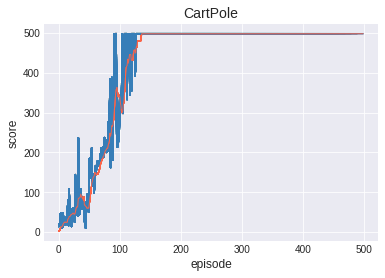

In [ ]:
import torch
import gym
import torch.optim as optim
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd

PPO_rewards = []

class MlpPolicy(nn.Module):
    def __init__(self, action_size, input_size=4):
        super(MlpPolicy, self).__init__()
        self.action_size = action_size
        self.input_size = input_size
        self.fc1 = nn.Linear(self.input_size, 24)
        self.fc2 = nn.Linear(24, 24)
        self.fc3_pi = nn.Linear(24, self.action_size)
        self.fc3_v = nn.Linear(24, 1)
        self.tanh = nn.Tanh()
        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=-1)

    def pi(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_pi(x)
        return self.softmax(x)

    def v(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.fc3_v(x)
        return x

class AgentConfig:
    gamma = 0.99
    plot_every = 10
    update_freq = 1
    k_epoch = 3
    learning_rate = 0.02
    lmbda = 0.95
    eps_clip = 0.2
    v_coef = 1
    entropy_coef = 0.01
    memory_size = 400

    train_cartpole = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class Agent(AgentConfig):
    def __init__(self):
        self.env = gym.make('CartPole-v1')
        self.action_size = self.env.action_space.n
        if self.train_cartpole:
            self.policy_network = MlpPolicy(action_size=self.action_size).to(device)
        self.optimizer = optim.Adam(self.policy_network.parameters(), lr=self.learning_rate)
        self.scheduler = optim.lr_scheduler.StepLR(self.optimizer, step_size=self.k_epoch,
                                                   gamma=0.999)
        self.loss = 0
        self.criterion = nn.MSELoss()
        self.memory = {
            'state': [], 'action': [], 'reward': [], 'next_state': [], 'action_prob': [], 'terminal': [], 'count': 0,
            'advantage': [], 'td_target': torch.FloatTensor([])
        }

    def new_random_game(self):
        self.env.reset()
        action = self.env.action_space.sample()
        screen, reward, terminal, info = self.env.step(action)
        return screen, reward, action, terminal

    def train(self):
        episode = 0
        step = 0
        reward_history = []
        avg_reward = []
        solved = False

        while not solved:
            start_step = step
            episode += 1
            episode_length = 0

            state, reward, action, terminal = self.new_random_game()
            current_state = state
            total_episode_reward = 1

            while not solved:
                step += 1
                episode_length += 1

                prob_a = self.policy_network.pi(torch.FloatTensor(current_state).to(device))

                action = torch.distributions.Categorical(prob_a).sample().item()

                state, reward, terminal, _ = self.env.step(action)
                new_state = state

                reward = -1 if terminal else reward

                self.add_memory(current_state, action, reward/10.0, new_state, terminal, prob_a[action].item())

                current_state = new_state
                total_episode_reward += reward

                if terminal:
                    PPO_rewards.append(total_episode_reward)
                    episode_length = step - start_step
                    reward_history.append(total_episode_reward)
                    avg_reward.append(sum(reward_history[-10:])/10.0)

                    self.finish_path(episode_length)

                    if len(reward_history) > 500 :
                        solved = True

                    print('episode: %.2f, total step: %.2f, last_episode length: %.2f, last_episode_reward: %.2f, '
                          'loss: %.4f, lr: %.4f' % (episode, step, episode_length, total_episode_reward, self.loss,
                                                    self.scheduler.get_lr()[0]))

                    self.env.reset()

                    break

            if episode % self.update_freq == 0:
                for _ in range(self.k_epoch):
                    self.update_network()

            if episode % self.plot_every == 0:
                plot_graph(reward_history, avg_reward)

        self.env.close()

    def update_network(self):
        pi = self.policy_network.pi(torch.FloatTensor(self.memory['state']).to(device))
        new_probs_a = torch.gather(pi, 1, torch.tensor(self.memory['action']).to(device))
        old_probs_a = torch.FloatTensor(self.memory['action_prob']).to(device)
        ratio = torch.exp(torch.log(new_probs_a) - torch.log(old_probs_a))

        surr1 = ratio * torch.FloatTensor(self.memory['advantage']).to(device)
        surr2 = torch.clamp(ratio, 1 - self.eps_clip, 1 + self.eps_clip) * torch.FloatTensor(self.memory['advantage']).to(device)
        pred_v = self.policy_network.v(torch.FloatTensor(self.memory['state']).to(device))
        v_loss = 0.5 * (pred_v - torch.FloatTensor(self.memory['td_target']).to(device)).pow(2)  # Huber loss
        entropy = torch.distributions.Categorical(pi).entropy()
        entropy = torch.tensor([[e] for e in entropy]).to(device)
        self.loss = (-torch.min(surr1, surr2) + self.v_coef * v_loss - self.entropy_coef * entropy).mean()

        self.optimizer.zero_grad()
        self.loss.backward()
        self.optimizer.step()
        self.scheduler.step()

    def add_memory(self, s, a, r, next_s, t, prob):
        if self.memory['count'] < self.memory_size:
            self.memory['count'] += 1
        else:
            self.memory['state'] = self.memory['state'][1:]
            self.memory['action'] = self.memory['action'][1:]
            self.memory['reward'] = self.memory['reward'][1:]
            self.memory['next_state'] = self.memory['next_state'][1:]
            self.memory['terminal'] = self.memory['terminal'][1:]
            self.memory['action_prob'] = self.memory['action_prob'][1:]
            self.memory['advantage'] = self.memory['advantage'][1:]
            self.memory['td_target'] = self.memory['td_target'][1:]

        self.memory['state'].append(s)
        self.memory['action'].append([a])
        self.memory['reward'].append([r])
        self.memory['next_state'].append(next_s)
        self.memory['terminal'].append([1 - t])
        self.memory['action_prob'].append(prob)

    def finish_path(self, length):
        state = self.memory['state'][-length:]
        reward = self.memory['reward'][-length:]
        next_state = self.memory['next_state'][-length:]
        terminal = self.memory['terminal'][-length:]

        td_target = (torch.FloatTensor(reward).to(device) + \
                    self.gamma * self.policy_network.v(torch.FloatTensor(next_state).to(device)) * torch.FloatTensor(terminal).to(device)).cpu()
        delta = td_target - self.policy_network.v(torch.FloatTensor(state).to(device)).cpu()
        delta = delta.detach().numpy()

        advantages = []
        adv = 0.0
        for d in delta[::-1]:
            adv = self.gamma * self.lmbda * adv + d[0]
            advantages.append([adv])
        advantages.reverse()

        if self.memory['td_target'].shape == torch.Size([1, 0]):
            self.memory['td_target'] = td_target.data
        else:
            self.memory['td_target'] = torch.cat((self.memory['td_target'], td_target.data), dim=0)
        self.memory['advantage'] += advantages


def plot_graph(reward_history, avg_reward):
    df = pd.DataFrame({'x': range(len(reward_history)), 'Reward': reward_history, 'Average': avg_reward})
    plt.style.use('seaborn-darkgrid')
    palette = plt.get_cmap('Set1')

    plt.plot(df['x'], df['Reward'], color=palette(1))
    plt.plot(df['x'], df['Average'], marker='', color='tomato', linewidth=1, alpha=0.9, label='Average')
    
    plt.title("CartPole", fontsize=14)
    plt.xlabel("episode", fontsize=12)
    plt.ylabel("score", fontsize=12)

    plt.savefig('score.png')

agent = Agent()
agent.train()

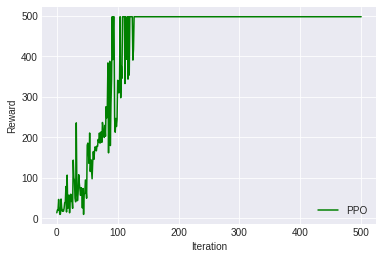

In [ ]:
plt.plot(PPO_rewards, label = 'PPO', color = 'green')
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend(loc='lower right')
plt.savefig('a2c_rewards.png', format='png', dpi=300)

Text(0, 0.5, 'reward')

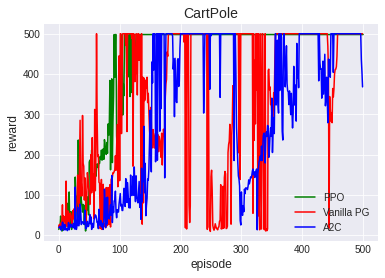

In [ ]:
plt.plot(PPO_rewards, label='PPO', color = 'green')
plt.plot(vpg_rewards,label='Vanilla PG', color = 'red')
plt.plot(a2c_rewards,label='A2C', color = 'blue')
plt.legend(loc='lower right')
plt.title("CartPole", fontsize=14)
plt.xlabel("episode", fontsize=12)
plt.ylabel("reward", fontsize=12)